<a href="https://colab.research.google.com/github/LxMera/Deep-Learning---denoising-rs-fMRI/blob/master/Training_with_CNN_3_axis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data (time series - Labels - maps)
HCP_hp2000       TR=0.7

COLOR-HCP_hp2000.zip

PCA-HCP_hp2000.zip

Umbral-HCP_hp2000.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.system('cp drive/My\ Drive/DatosDeepLearning/COLOR-HCP_hp2000.zip HCP_hp2000.zip')
os.system('unzip HCP_hp2000.zip')

0

In [3]:
os.system('wget -nc https://www.dropbox.com/s/n9zq7srft09ef76/main_features.py?dl=1')  
os.system('mv main_features.py?dl=1 main_features.py')
os.system('wget -nc https://www.dropbox.com/s/m432eescwggki6t/model1.py?dl=1')
os.system('mv model1.py?dl=1 model1.py')

0

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import glob
import main_features as mf
import model1 as mod
from sklearn.preprocessing import StandardScaler
import cv2
import os
import sys
import random
import warnings
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Activation
print (tf.__version__)

Using TensorFlow backend.


1.15.0


In [0]:
series = scipy.io.loadmat('HCP_hp2000/Data.mat')
labels = scipy.io.loadmat('HCP_hp2000/Labels.mat')
order = scipy.io.loadmat('HCP_hp2000/Order.mat')

In [0]:
Data=series[list(series.keys())[-1]]
Labe=labels[list(labels.keys())[-1]]
Orde= order[list(order.keys())[-1]]

Data=np.transpose(Data)
Labe=np.array(np.transpose(Labe)[:,0], np.dtype('int'))
TR=0.7

In [7]:
print('Components and time points', np.shape(Data))
print('Labels of componets       ', np.shape(Labe))
print('Order of brain maps       ', np.shape(Orde))

Components and time points (22877, 1200)
Labels of componets        (22877,)
Order of brain maps        (22877,)


In [8]:
#percentage
per=int(np.shape(Data)[0]*0.8)

X_test=Data[per:]
X_train=Data[:per]
y_test=Labe[per:]
y_train=Labe[:per]
TEST_PATH=Orde[per:]
TRAIN_PATH=Orde[:per]

print('training data   ', X_train.shape)
print('test data       ', X_test.shape)

print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', TRAIN_PATH.shape)
print('test maps       ', TEST_PATH.shape)

training data    (18301, 1200)
test data        (4576, 1200)
training labels  (18301,)
test labels      (4576,)
training maps    (18301,)
test maps        (4576,)


# CNN

In [9]:
print('Components and time points', np.shape(Data))
print('Labels of componets       ', np.shape(Labe))
print('Order of brain maps       ', np.shape(Orde))

Components and time points (22877, 1200)
Labels of componets        (22877,)
Order of brain maps        (22877,)


In [0]:
Signal=np.array(np.where(Labe==1))[0]

### Validation of images

In [11]:
tax=300
cont=0

files=np.sort(glob.glob('HCP_hp2000/*.png'))
ima=cv2.imread(files[0],0)[:,:109]
siz=(np.shape(ima)[0])*np.shape(ima)[1]
ind = np.random.permutation(np.shape(files)[0])
files=files[ind]
files=files[:tax]

for i in range(tax):
  name=files[i]
  #print(name)
  ima=cv2.imread(name,0)[:,:109]
  for j in range(tax):
    name2=files[j]
    ima2=cv2.imread(name2,0)[:,:109]
    sumx=np.sum(ima==ima2)
    if sumx==siz:
      #print('Here's one')
      cont=cont+1

if cont==tax:
  print('Different Images')
else:
  print('There are equal images')

Different Images


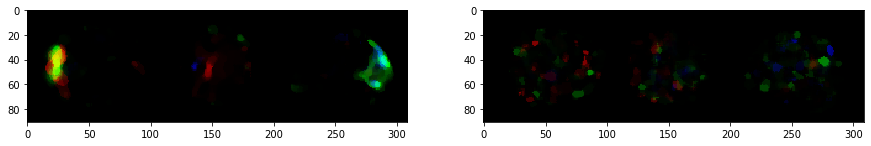

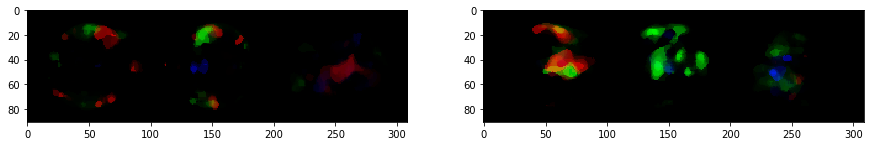

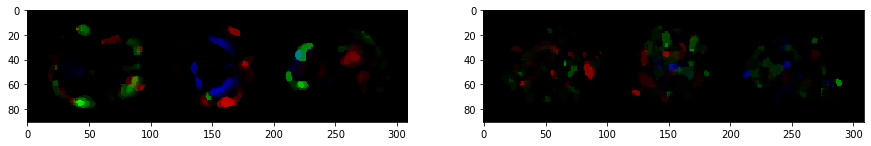

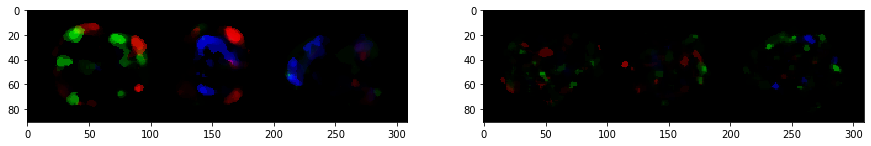

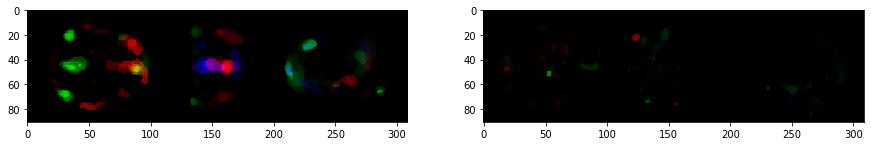

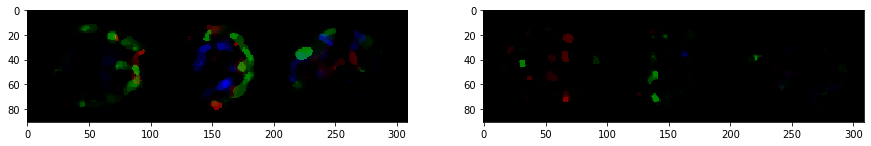

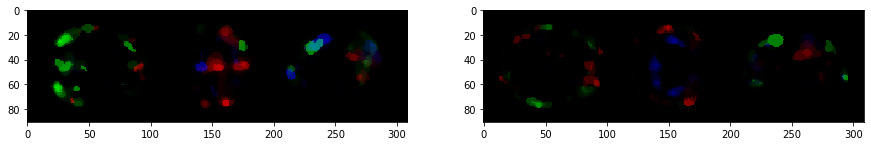

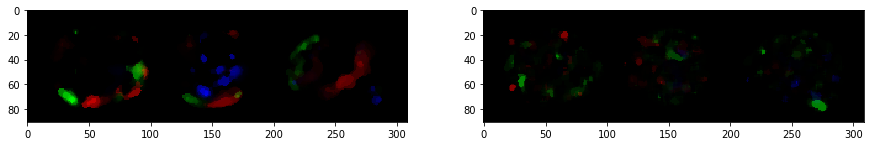

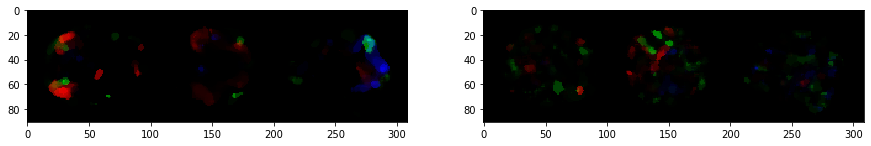

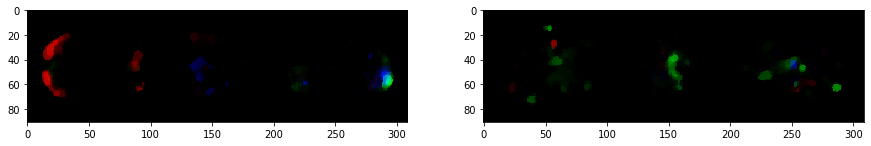

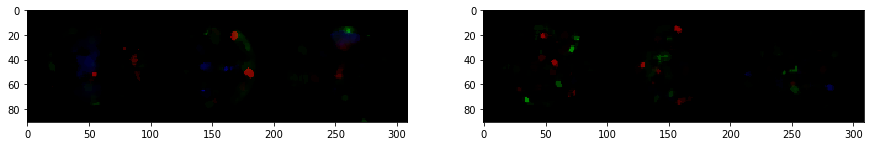

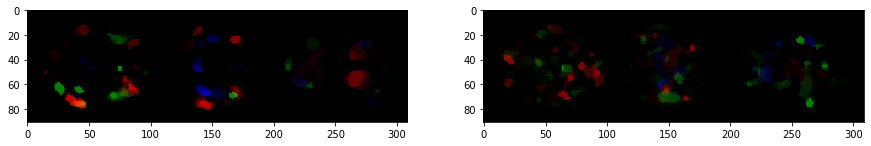

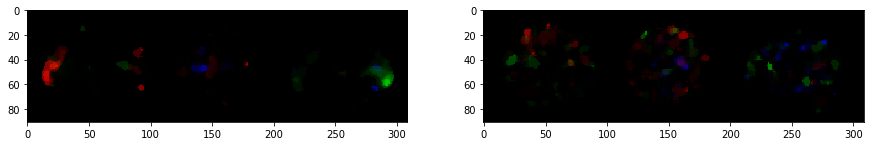

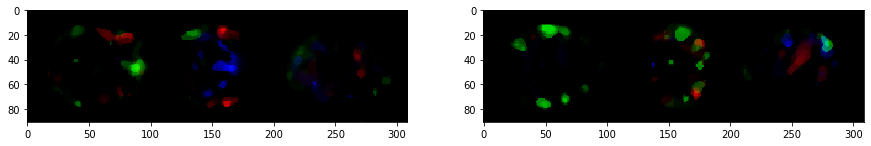

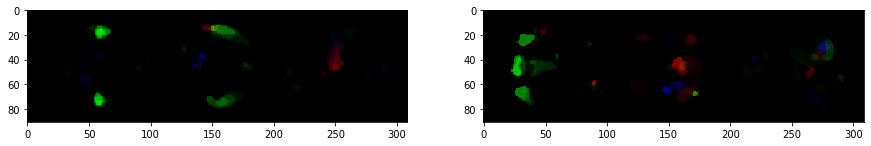

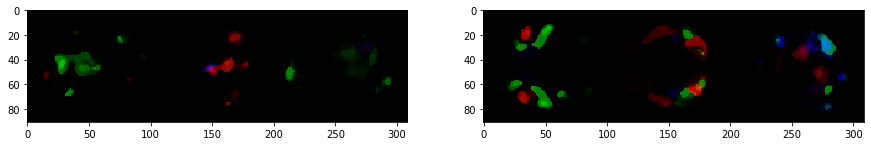

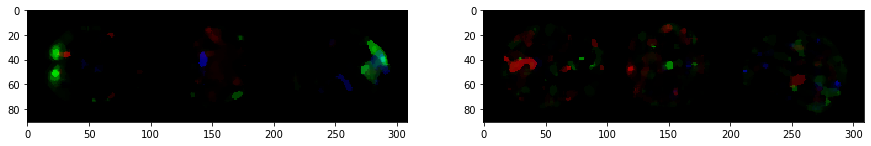

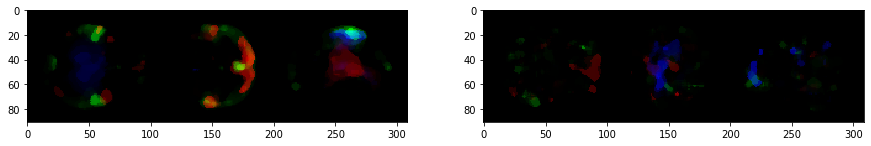

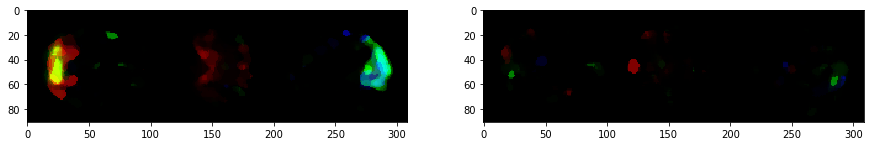

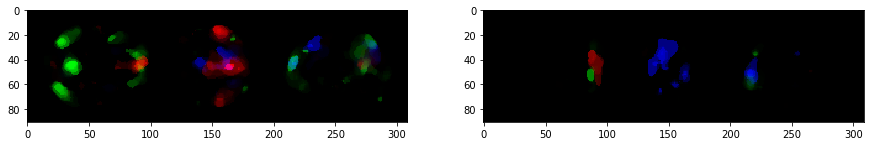

In [58]:
for j in range(20):
  ima1=cv2.imread(Orde[Signal[20+j]].strip())#[:,:109,:]
  ima2=cv2.imread(files[j].strip())#[:,:109,:]

  ima1=cv2.medianBlur(ima1, 7)
  ima2=cv2.medianBlur(ima2, 7)

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.imshow(ima1)
  plt.subplot(1,2,2)
  plt.imshow(ima2)

In [60]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=np.shape(ima1)
nb_classes=2
print(np.shape(ima1))

(91, 309, 3)


In [0]:
M_train = np.zeros((len(TRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
for n in range(len(TRAIN_PATH)):
  name=TRAIN_PATH[n].strip()
  ima=cv2.imread(name)#[:,:109,:]
  ima=cv2.medianBlur(ima, 7)
  ima=np.array(ima)
  M_train[n]=ima

In [0]:
M_test = np.zeros((len(TEST_PATH), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
for n in range(len(TEST_PATH)):
  name=TEST_PATH[n].strip()
  ima=cv2.imread(name)#[:,:109,:]
  ima=cv2.medianBlur(ima, 7)
  ima=np.array(ima)
  M_test[n]=ima

In [63]:
print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', M_train.shape)
print('test maps       ', M_test.shape)

training labels  (18301,)
test labels      (4576,)
training maps    (18301, 91, 309, 3)
test maps        (4576, 91, 309, 3)


In [0]:
reg=0.4

In [0]:
#funcion para establecer el modelo
def get_model():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) #Capa de entrada
    s = Lambda(lambda x: x / 255) (inputs)                #Capa no entrenable o funcion (normaliza las ima)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #convolucion
    c1 = Dropout(reg) (c1)                                                                        #regularizacion 0
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)#convolucion
    c1 = MaxPooling2D((2, 2)) (c1)                                                                #reduccion de dim
    
    c6 = Flatten()(c1)
    
    c6 = Dense(16, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
    c6 = Dense(8, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
    c6 = Dense(4, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])    
    return model

In [66]:
del model
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 309, 3)]      0         
_________________________________________________________________
lambda (Lambda)              (None, 91, 309, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 309, 16)       448       
_________________________________________________________________
dropout (Dropout)            (None, 91, 309, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 309, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 154, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 110880)            0     

In [67]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('drive/My Drive/DatosDeepLearning/Arq_16_16_3D-3-axis_with_medianblur7.h5', verbose=1, save_best_only=True)
results = model.fit(M_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Train on 16470 samples, validate on 1831 samples
Epoch 1/50
16448/16470 [============================>.] - ETA: 0s - loss: 0.3636 - acc: 0.8915
Epoch 00001: val_loss improved from inf to 0.21460, saving model to drive/My Drive/DatosDeepLearning/Arq_16_16_3D-3-axis_with_medianblur7.h5
16470/16470 [==============================] - 26s 2ms/sample - loss: 0.3633 - acc: 0.8916 - val_loss: 0.2146 - val_acc: 0.8962
Epoch 2/50
16448/16470 [============================>.] - ETA: 0s - loss: 0.2739 - acc: 0.9087
Epoch 00002: val_loss improved from 0.21460 to 0.13305, saving model to drive/My Drive/DatosDeepLearning/Arq_16_16_3D-3-axis_with_medianblur7.h5
16470/16470 [==============================] - 27s 2ms/sample - loss: 0.2736 - acc: 0.9089 - val_loss: 0.1331 - val_acc: 0.9470
Epoch 3/50
16464/16470 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9241
Epoch 00003: val_loss did not improve from 0.13305
16470/16470 [==============================] - 26s 2ms/sample - loss: 0.2

In [68]:
test_preds = model.predict(M_test).argmax(axis=1)
Accuracy = np.mean(test_preds == y_test)
print(Accuracy)

0.9849213286713286


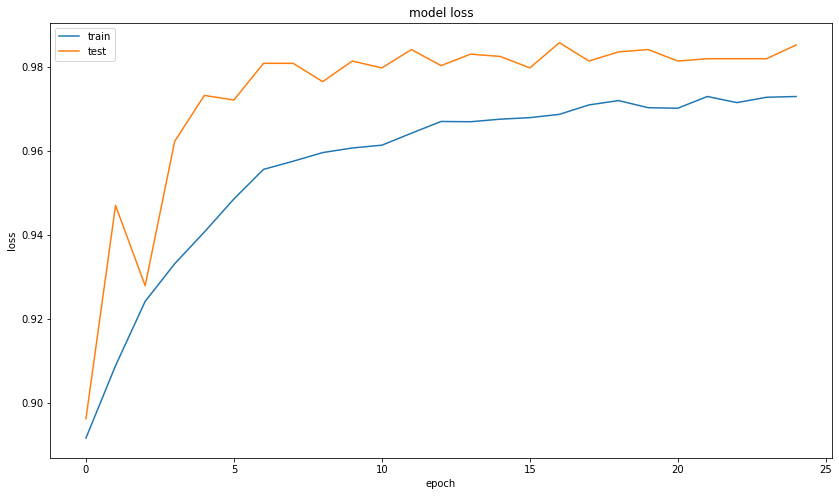

In [69]:
#%matplotlib inline
plt.figure(figsize=(14,8))
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Resultados:
Se entrenó la red con las imágenes obtenidas mediante la compresión de los 3 ejes (sagital, coronal y axial) por PCA. 

Se entrenó inicialmente con las imágenes obtenidas por los cortes axiales, sin embargo, la precisión se mantuvo cerca del 89% y la validación cruzada dió el mismo valor para todas las epocas (0.8951%), por lo tanto, se procedió a agregar un paso adicional en la validación de las imágenes, donde se tomó una muestra aleatoria y se encontró que ninguna de las imágenes estaba repetida o se habia sobre escrito.

Se entrenó también con los 3 planos (sagital, coronal, axil), no obstante, el resultado fue similar al caso anterior. 

En este caso, se puede concluir que a pesar que PCA es util para eliminar una de las dimensiones del volumen que conforma la componente independiente, pierde demasiada información del volumen real.

Nota: La mayoría de entrenamiento no superaban las 20 epocas debido a que no había una mejora en la precisión.

Con un filtro median blur de tamaño 7 dio una precisión de 0.9643793706293706 con PCA

Con la compresión binaria en el eje axial dió una presición de: 0.9781468531468531

Con la compresión binaria en los 3 ejes dió una presición de: 0.9849213286713286